In [1]:
try:
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    import pandas as pd
    import numpy as np
    import os
    import statsmodels.api as sm
    import sklearn.linear_model as lm
    import sklearn.model_selection as skm
    import statsmodels.formula.api as smf
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from ISLP.models import ModelSpec as MS
    from stargazer.stargazer import Stargazer
    from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
    from sklearn.metrics import (accuracy_score,
                             log_loss,
                                mean_squared_error)
    from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
    from ISLP.bart import BART
    import xgboost as xgb
    from sklearn.model_selection import cross_val_predict
    from sklearn.neural_network import MLPRegressor
    #import doubleml as dml
    import graphviz
    import networkx as nx
    import dowhy
    from dowhy import CausalModel
    

except ModuleNotFoundError:
    !pip install ISLP -q
    !pip install stargazer -q
    !pip install xgboost -q
    !pip install doubleml -q
    !pip install dowhy -q
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    import pandas as pd
    import numpy as np
    import os
    import statsmodels.api as sm
    import sklearn.linear_model as lm
    import sklearn.model_selection as skm
    import statsmodels.formula.api as smf
    import matplotlib.pyplot as plt
    from stargazer.stargazer import Stargazer
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from ISLP.models import ModelSpec as MS
    from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
    from sklearn.metrics import (accuracy_score,
                             log_loss,
                                mean_squared_error)
    from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
    from ISLP.bart import BART
    import xgboost as xgb
    from sklearn.model_selection import cross_val_predict
    #import doubleml as dml
    import graphviz
    import networkx as nx
    import dowhy
    from dowhy import CausalModel

In [2]:
data_loc = "spillovers.dta"

data = pd.read_stata(data_loc, iterator=True)

In [3]:
data.variable_labels()

{'cusip': 'CUSIP',
 'year': 'year',
 'xrd': 'Expenditure on R&D',
 'ppent': 'Net book value of property, plant and equipment',
 'spillsic': 'SIC correlation weighted R&D of other firms, 1996 values',
 'spillcovsic': '',
 'spillmalsic': '',
 'spillmalcovsic': '',
 'spilltec': 'Patent NClass correlation weighted R&D of other firms, 1996 values',
 'spillcovtec': '',
 'spillmaltec': '',
 'spillmalcovtec': '',
 'spilltloc': '',
 'spillsloc': '',
 'spilltectloc': '',
 'spilltecsloc': '',
 'spillsicsloc': '',
 'spillsictloc': '',
 'lstate': '',
 'lfirm': '',
 'firm_dum': '',
 'hxrd': '',
 'spillsicIV': '',
 'spilltecIV': '',
 'spillsicIV_mal': '',
 'spilltecIV_mal': '',
 'p005': '',
 'sales_ind': 'Control variable - Total sales weighted by sic sales matrix',
 'sales_ind_ns': 'Control variable - Total Value Shipments in Manufacturing from National Statisti',
 'patents_ind': 'Control variable - Total number of patents weighted by tech matrix',
 'pat_count': 'Patents per firm applied for that ye

In [4]:
vars_of_int = ['i','year','rmkvaf','grd','grd_k1','rxrd','gspillsic','gspilltec','pat_count','pat_cite','rsales',
              'rppent','emp','gspilltecIV','gspillsicIV']

data = pd.read_stata(data_loc)
df = data[vars_of_int]
df.columns

Index(['i', 'year', 'rmkvaf', 'grd', 'grd_k1', 'rxrd', 'gspillsic',
       'gspilltec', 'pat_count', 'pat_cite', 'rsales', 'rppent', 'emp',
       'gspilltecIV', 'gspillsicIV'],
      dtype='object')

In [5]:
# convert categorical columns to strings
df['year'] = df['year'].astype(str)
df['i'] = df['i'].astype(str)

/tmp/ipykernel_177/3340598184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['year'].astype(str)
/tmp/ipykernel_177/3340598184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['i'] = df['i'].astype(str)


In [6]:
var_of_int_noindex = ['rmkvaf','gspilltecIV','gspillsicIV','pat_count','rsales','rppent','emp','rxrd']

# delete NaN values

df = df.dropna(axis=0)

#for i in range(0, len(var_of_int_noindex)):
#    df = df[df[var_of_int_noindex[i]].isna() == False]

#df = df.loc[df['rmkvaf'].isna() == False]

df_sum_stats = df[var_of_int_noindex].describe()
df_sum_stats = df_sum_stats.round(2)
df_sum_stats

,rmkvaf,gspilltecIV,gspillsicIV,pat_count,rsales,rppent,emp,rxrd
count,11736.00,11736.00,11736.00,11736.00,11736.00,11736.00,11736.00,11736.00
mean,3449.07,20747.15,5980.43,18.43,2728.76,1289.43,18.36,101.31
std,13571.64,15482.72,8665.92,80.25,8369.00,3991.58,53.39,457.04
min,0.43,230.28,4.46,0.00,1.48,0.96,0.10,0.00
25%,86.55,8901.98,596.31,0.00,113.19,26.77,1.08,0.00
50%,395.46,17242.42,2027.41,1.00,433.49,116.75,3.71,4.53
75%,1934.38,29073.87,7382.01,6.00,1876.15,710.58,13.53,29.16
max,485566.69,91985.96,55576.60,2405.00,137513.77,72707.55,876.80,8900.00


In [7]:
#df_sum_stats.T.to_excel("sum_stats.xlsx") # export summary statistics
print(df_sum_stats.T.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max \\
\midrule
rmkvaf & 11736.000000 & 3449.070000 & 13571.640000 & 0.430000 & 86.550000 & 395.460000 & 1934.380000 & 485566.690000 \\
gspilltecIV & 11736.000000 & 20747.150000 & 15482.720000 & 230.280000 & 8901.980000 & 17242.420000 & 29073.870000 & 91985.960000 \\
gspillsicIV & 11736.000000 & 5980.430000 & 8665.920000 & 4.460000 & 596.310000 & 2027.410000 & 7382.010000 & 55576.600000 \\
pat_count & 11736.000000 & 18.430000 & 80.250000 & 0.000000 & 0.000000 & 1.000000 & 6.000000 & 2405.000000 \\
rsales & 11736.000000 & 2728.760000 & 8369.000000 & 1.480000 & 113.190000 & 433.490000 & 1876.150000 & 137513.770000 \\
rppent & 11736.000000 & 1289.430000 & 3991.580000 & 0.960000 & 26.770000 & 116.750000 & 710.580000 & 72707.550000 \\
emp & 11736.000000 & 18.360000 & 53.390000 & 0.100000 & 1.080000 & 3.710000 & 13.530000 & 876.800000 \\
rxrd & 11736.000000 & 101.310000 & 457.040000 & 0.000000 & 0.000000 & 4.

# OLS Regression

In [8]:
# Run linear model
# gen fixed effects
time_effects = pd.get_dummies(df['year'])
#time_effects.columns = time_effects.columns.astype(str)
firm_effects = pd.get_dummies(df['i'])
#time_effects.columns = time_effects.columns.astype(str)


df = pd.merge(df, time_effects, left_on=df.index, right_on=time_effects.index, how='left')

df = df.rename(columns={'key_0': 'old_key'})

df = pd.merge(df, firm_effects, left_on=df['old_key'], right_on=firm_effects.index, how='left')

fixed_effects = list(time_effects.columns.values)
for col in firm_effects.columns.values:
    fixed_effects.append(col)

y_var = df['rmkvaf']

# get df for x vars + fixed effects
x_vars = ['gspilltecIV','gspillsicIV','pat_count','rsales','rppent','emp','rxrd']
for col in fixed_effects:
    x_vars.append(col)


In [9]:
x_vars = df[x_vars]
x_vars = sm.add_constant(x_vars)
x_vars = x_vars.astype(float) # converts categorical booleans to floats

lin_reg = sm.OLS(y_var,x_vars).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rmkvaf   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     28.98
Date:                Mon, 14 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:18:31   Log-Likelihood:            -1.2192e+05
No. Observations:               11736   AIC:                         2.454e+05
Df Residuals:                   10985   BIC:                         2.509e+05
Df Model:                         750                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6271.8534    532.282    -11.783      0.000   -7315.222   -5228.485
gspilltecIV     0.1630      0.028      5.768      0.000       0.108       0.218
gspillsicIV     0.4887      0.052      9.386      0.000       0.387       0.591
pat_count     -29.4376      1.715    -17.168      0.000     -32.799     -26.076
rsales          1.0154      0.041     24.569      0.000       0.934       1.096
rppent          0.5175      0.087      5.962      0.000       0.347       0.688
emp            -2.5097      7.030     -0.357      0.721     -16.291      11.271
rxrd            8.6216      0.669     12.878      0.000       7.309       9.934
1981          762.8261    381.627      1.999      0.046      14.769    1510.883
1982          883.7420    369.574      2.391      0.017     159.310    1608.174
1983          821.5707    357.444      2.298      0.022     120.917    1522.225
1984          310.9095    346.828      0.896      0.370    -368.935     990.754
1985          112.7209    339.088      0.332      0.740    -551.953     777.395
1986         -152.9965    330.737     -0.463      0.644    -801.300     495.307
1987         -423.0556    324.228     -1.305      0.192   -1058.600     212.489
1988         -777.3124    321.303     -2.419      0.016   -1407.124    -147.500
1989         -661.1419    317.261     -2.084      0.037   -1283.031     -39.252
1990        -1153.5785    313.432     -3.680      0.000   -1767.961    -539.196
1991         -798.2414    312.074     -2.558      0.011   -1409.962    -186.521
1992         -982.2983    312.534     -3.143      0.002   -1594.921    -369.676
1993         -999.6691    313.254     -3.191      0.001   -1613.703    -385.635
1994        -1323.3880    317.300     -4.171      0.000   -1945.352    -701.424
1995         -816.2328    325.043     -2.511      0.012   -1453.375    -179.091
1996         -732.9858    338.616     -2.165      0.030   -1396.733     -69.238
1997         -349.2790    356.979     -0.978      0.328   -1049.022     350.464
1998         -247.3364    381.255     -0.649      0.517    -994.665     499.993
1999          253.8930    408.826      0.621      0.535    -547.480    1055.266
10005.0      3097.6615   1880.996      1.647      0.100    -589.430    6784.753
10006.0      2317.7560   2276.237      1.018      0.309   -2144.079    6779.591
10008.0      1438.1417   1886.554      0.762      0.446   -2259.844    5136.127
10016.0      2713.9470   1892.028      1.434      0.151    -994.769    6422.663
10030.0      5086.2191   1901.323      2.675      0.007    1359.283    8813.155
1004.0       4105.1769   1889.911      2.172      0.030     400.612    7809.742
10056.0      1739.8066   1873.446      0.929      0.353   -1932.485    5412.099
10085.0     -3584.2178   1887.069     -1.899      0.058   -7283.212     114.777
10092.0      3969.6072   4695.384      0.84

In [10]:
# export results, omit fixed effects
stargazer = Stargazer([lin_reg])

main_vars = [col for col in x_vars.columns if col not in fixed_effects]
cov_labels = {'rmkvaf': 'Market Value',
             'pat_count': 'Patent Count',
             'rsales': 'Sales',
             'rppent': '',
             'emp': 'Employment',
             'rxrd': 'R&D Expenditures'}


stargazer.covariate_order(main_vars)
stargazer.add_line("Firm & Time Effects", ['Yes'])
#stargazer.rename_covariates(cov_labels)
stargazer

In [11]:
# render to latex
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable: rmkvaf}} \
\cr \cline{2-2}
\\[-1.8ex] & (1) \\
\hline \\[-1.8ex]
 const & -6271.853$^{***}$ \\
& (532.282) \\
 gspilltecIV & 0.163$^{***}$ \\
& (0.028) \\
 gspillsicIV & 0.489$^{***}$ \\
& (0.052) \\
 pat_count & -29.438$^{***}$ \\
& (1.715) \\
 rsales & 1.015$^{***}$ \\
& (0.041) \\
 rppent & 0.518$^{***}$ \\
& (0.087) \\
 emp & -2.510$^{}$ \\
& (7.030) \\
 rxrd & 8.622$^{***}$ \\
& (0.669) \\
 Firm & Time Effects & Yes \\
\hline \\[-1.8ex]
 Observations & 11736 \\
 $R^2$ & 0.664 \\
 Adjusted $R^2$ & 0.641 \\
 Residual Std. Error & 8127.834 (df=10985) \\
 F Statistic & 28.979$^{***}$ (df=750; 10985) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


# Ridge Regression

In [12]:
# design = MS(df.columns.drop([col for col in df.columns if col not in x_vars.columns])).fit(df)
# NOTE: including all of the fixed effects seems to kill the notebook. Running Ridge/LASSO on subset excluding FE's

# Check: outlier in dataset driving a split in reg tree.
## Drop two outlier firms: i = 5047, i = 12141, i = 6008
df = df.loc[(df['i'] != '5047.0') & (df['i'] != '12141.0') & (df['i'] != '6008.0')]

design = MS(df.columns.drop([col for col in df.columns if col not in x_vars.columns or col in fixed_effects])).fit(df)
Y = np.array(df['rmkvaf'])
X = design.transform(df)

D = design.fit_transform(df)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [13]:
df[['i','rmkvaf']].sort_values('rmkvaf', ascending=False)

,i,rmkvaf
785,20779.0,194111.171875
5965,62599.0,190356.171875
4626,6066.0,183853.468750
6493,7257.0,168679.343750
4625,6066.0,163628.187500
...,...,...
8873,9230.0,1.155449
948,13923.0,0.985430
9542,9799.0,0.718651
9543,9799.0,0.617000


In [14]:
design

ModelSpec(terms=Index(['rxrd', 'pat_count', 'rsales', 'rppent', 'emp', 'gspilltecIV',
       'gspillsicIV'],
      dtype='object'))

In [15]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = lm.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 692474979059.0005, tolerance: 138513639.2459772
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did 

In [16]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'

soln_path

,rxrd,pat_count,rsales,rppent,emp,gspilltecIV,gspillsicIV
negative log(lambda),,,,,,,
-9.167990,0.639117,0.386651,0.641837,0.580663,0.482584,0.281462,0.211692
-8.935406,0.806396,0.487844,0.809826,0.732642,0.608881,0.355125,0.267103
-8.702821,1.017432,0.615504,1.021757,0.924375,0.768208,0.448054,0.337010
-8.470237,1.283655,0.776541,1.289107,1.166247,0.969189,0.565280,0.425201
-8.237653,1.619474,0.979666,1.626344,1.471347,1.222693,0.713142,0.536452
...,...,...,...,...,...,...,...
12.927523,2655.969827,329.826780,2902.989773,1852.216527,-1012.994917,186.880161,982.580331
13.160108,2655.970437,329.826109,2902.995806,1852.215856,-1012.999948,186.879590,982.580723
13.392692,2655.970921,329.825577,2903.000587,1852.215323,-1013.003935,186.879138,982.581034


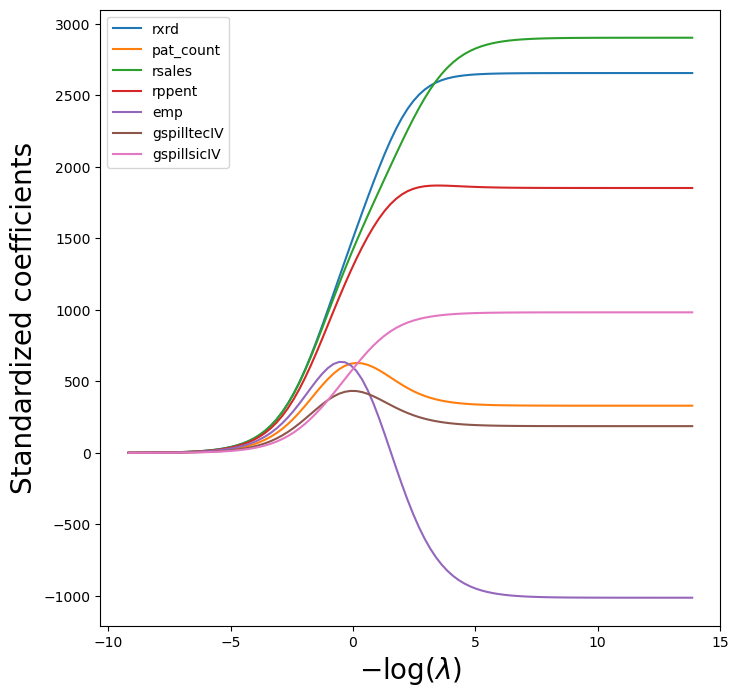

In [17]:
path_fig, ax = plt.subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left')

# save figure
plt.savefig('ridge_coef.png')

## Cross-Validation plot

In [18]:
# Using K-fold CV w/ K=5
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)

scaler = StandardScaler(with_mean=True,  with_std=True)
ridge = lm.ElasticNet(alpha=lambdas[59], l1_ratio=0)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])

param_grid = {'ridge__alpha': lambdas}

grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error') 
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

ridgeCV = lm.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

tuned_ridge = pipeCV.named_steps['ridge']

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.280e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.284e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.129e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.881e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.581e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.324e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.098e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.575e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.412e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.423e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.333e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.226e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.038e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.012e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.747e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.732e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.187e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.178e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.213e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.171e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.985e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.984e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.717e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.717e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.716e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.716e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316873049894.24744, tolerance: 105705701.29629055
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316857801712.4983, tolerance: 105705701.29629055
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordina

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311051219264.0425, tolerance: 92975378.35672489
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 305030072647.7236, tolerance: 92975378.35672489
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate 

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.877e+11, tolerance: 1.272e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


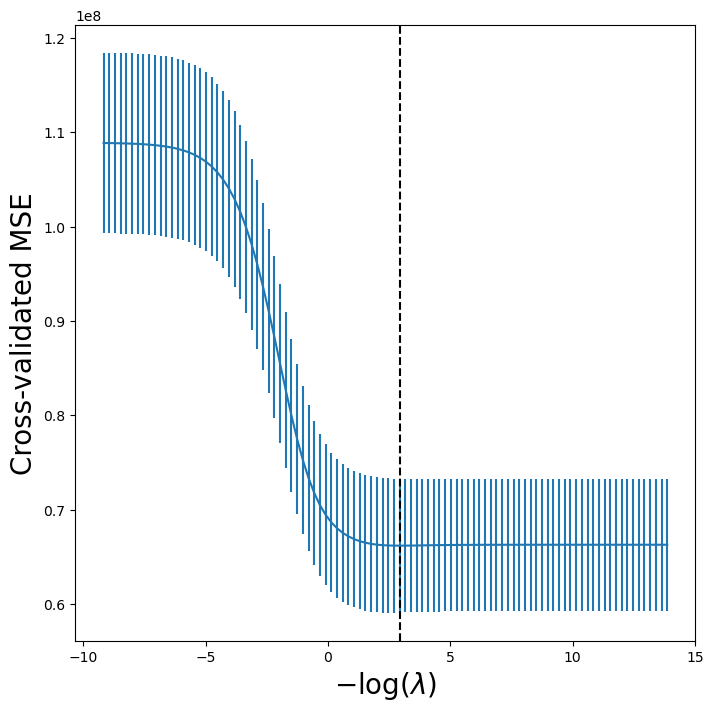

In [19]:
# Plot results
ridge_fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
#ax.set_ylim([80000000,220000000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

# save figure
plt.savefig('ridge_cv.png')

# LASSO Regression

In [20]:
lassoCV = lm.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

In [21]:
lambdas, soln_array = lm.Lasso.path(Xs,
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

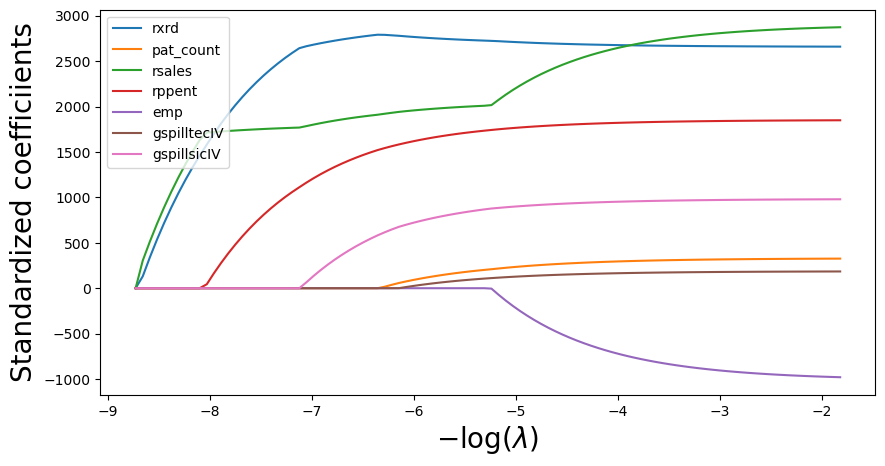

In [22]:
path_fig, ax = plt.subplots(figsize=(10,5))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20)

# save figure
plt.savefig('lasso_coef.png')

## Cross-Validation plot

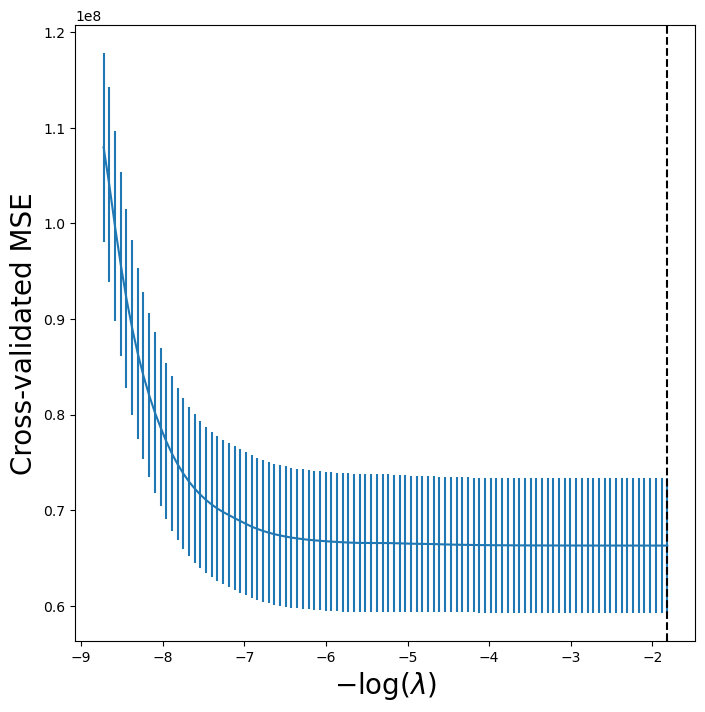

In [23]:
lassoCV_fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
#ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

# save figure
plt.savefig('lasso_cv.png')

In [24]:
# comparing lambdas

# tuned alphas
print("LASSO: ", tuned_lasso.alpha_)
print("Ridge: ", tuned_ridge.alpha_)

LASSO:  6.154565207638776
Ridge:  0.05358981380658186


In [25]:
print(-np.log(tuned_lasso.alpha_))

-1.8171941166276557


# Regression Tree

In [26]:
# Splitting sample
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                df['rmkvaf'],
                                test_size=0.3,
                                random_state=0)
feature_names = list(D.columns)

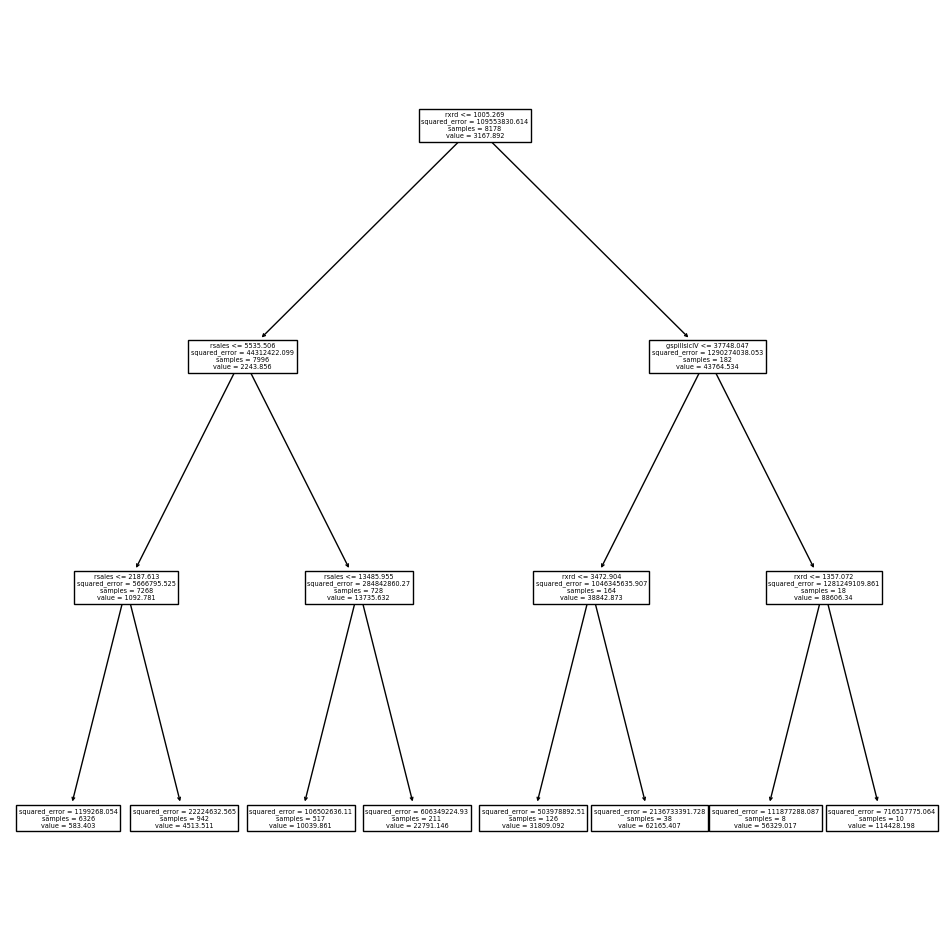

In [27]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = plt.subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

In [28]:
# Find best pruning for tree
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True, # retrains on best alpha
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [29]:
# Get prediction error
best_ = grid.best_estimator_
tree_mse = np.mean((y_test - best_.predict(X_test))**2)
tree_mse

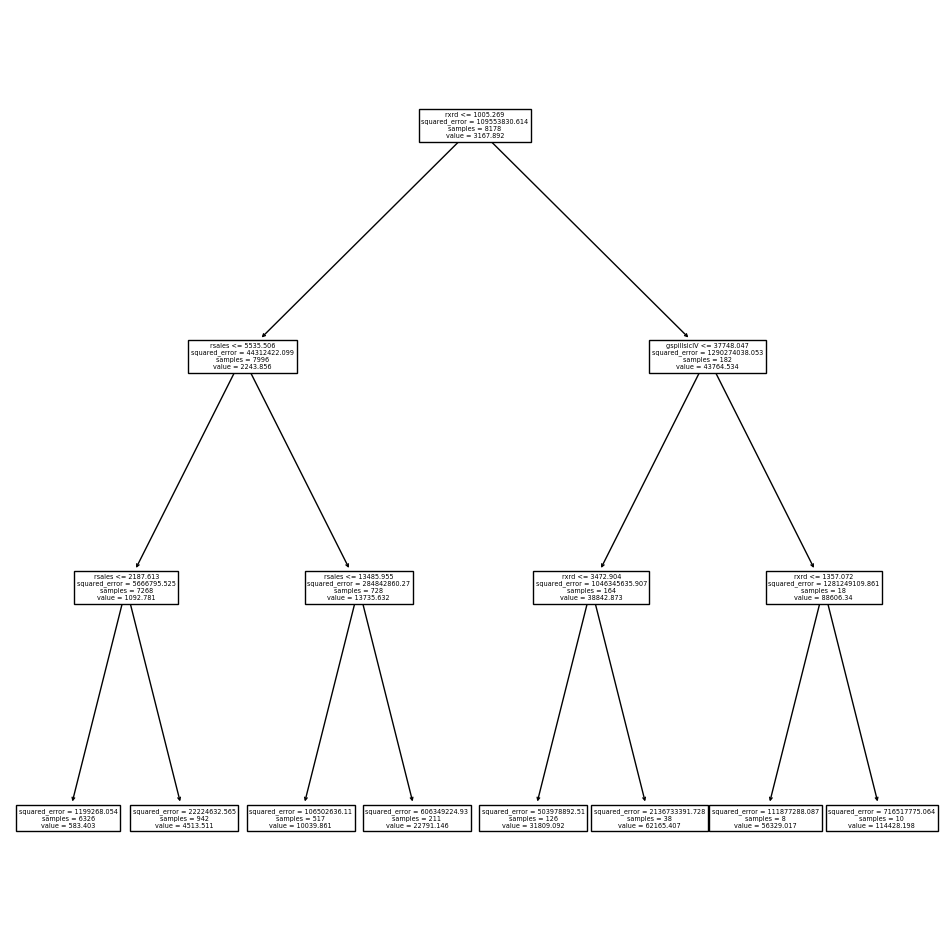

In [30]:
# Output pruned Regression Tree
ax = plt.subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);
plt.savefig("pruned_tree.png")

# Random Forest

In [31]:
RF_tree = RF(max_features=3, # Random forest model
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_tree.predict(X_test)
rf_mse = np.mean((y_test - y_hat_RF)**2)
rf_mse

In [32]:
feature_imp = pd.DataFrame(
    {'importance':RF_tree.feature_importances_},
    index=feature_names) # Must include feature importance in report
feature_imp = feature_imp.sort_values(by='importance', ascending=False)
feature_imp

,importance
rxrd,0.275551
rsales,0.264674
rppent,0.112891
gspillsicIV,0.111112
emp,0.103030
gspilltecIV,0.084416
pat_count,0.048326


Text(0.5, 1.0, 'Importance of Random Forest Regressors for Firm Market Value')

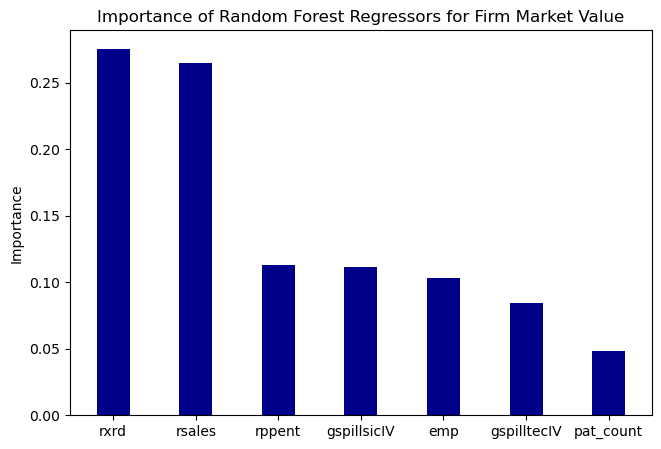

In [33]:
# print(feature_imp.sort_values(by='importance', ascending=False).to_latex()) # print latex output

# plot importance values
fig = plt.figure(figsize=(7.5,5))

plt.bar(feature_imp.index, feature_imp.importance, color ='darkblue', 
        width = 0.4)
plt.ylabel('Importance')
plt.title('Importance of Random Forest Regressors for Firm Market Value')

# Bagging

In [34]:
bag = RF(max_features=X_train.shape[1], random_state=0)
bag.fit(X_train, y_train)

RandomForestRegressor(max_features=7, random_state=0)

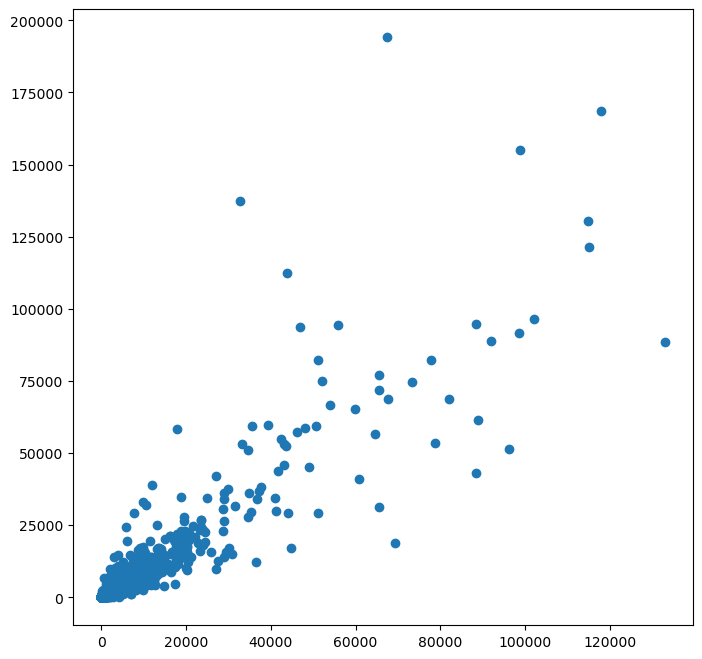

In [35]:
ax = plt.subplots(figsize=(8,8))[1]
y_hat_bag = bag.predict(X_test)
ax.scatter(y_hat_bag, y_test)
bag_mse = np.mean((y_test - y_hat_bag)**2)
bag_mse

# Boosting

In [36]:
boost = GBR(n_estimators=5000, # Gradient Boosting Regressor
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

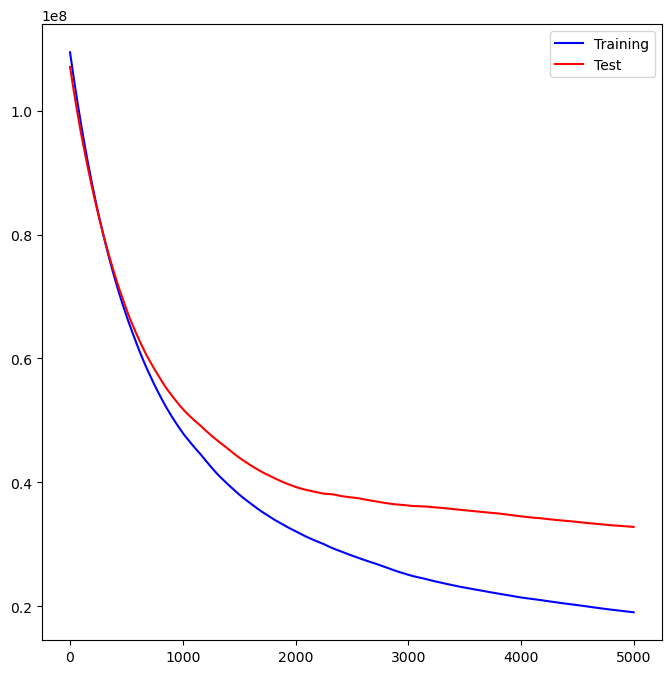

In [37]:
test_error = np.zeros_like(boost.train_score_)
for idx, y_ in enumerate(boost.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost.train_score_.shape[0])
ax = plt.subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

boost_mse = min(test_error)

Mean Squared Error: 38336824.0
Prev. MSE: 40865396.0


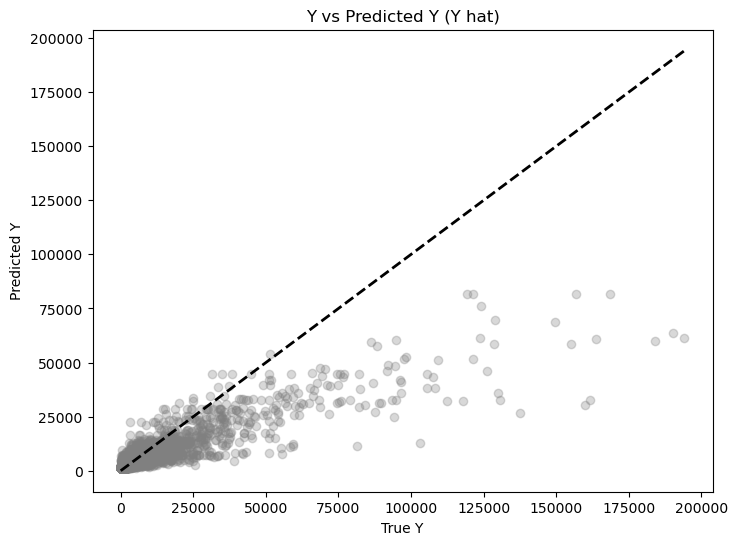

In [38]:
# XG Boost
y = df['rmkvaf']
# Convert the data into XGBoost's DMatrix format
dtrain = xgb.DMatrix(X, label=y)

# Define the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model with the optimal number of boosting rounds
model = xgb.train(params, dtrain, num_boost_round= 10)

# Make predictions 
y_pred = model.predict(dtrain)

# Calculate and print the Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
print("Prev. MSE: 40865396.0")

plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, c='grey', alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.title('Y vs Predicted Y (Y hat)')
plt.show()

# Comparing Test Errors

In [39]:
# Tree
print('Tree: ', tree_mse)
# Bag
print('Bag: ', bag_mse)
# Random Forest
print('Random Forest: ', rf_mse)
# Boost
print('Boost: ', boost_mse)

# Make table
error_tbl = {
    'model' : ['Tree', 'Bag', 'Random Forest', 'Boost'],
    'MSE' : [tree_mse, bag_mse, rf_mse, boost_mse]
}
error_tbl = pd.DataFrame(data=error_tbl)
print(error_tbl.to_latex())

Tree:  48364442.48004447
Bag:  20762300.97510542
Random Forest:  19778946.4332678
Boost:  32788863.102553938
\begin{tabular}{llr}
\toprule
 & model & MSE \\
\midrule
0 & Tree & 48364442.480044 \\
1 & Bag & 20762300.975105 \\
2 & Random Forest & 19778946.433268 \\
3 & Boost & 32788863.102554 \\
\bottomrule
\end{tabular}



# Predicting Market value of spillovers across years

In [40]:
# Use Optimal LASSO coefficients - remember to rescale from their standardization back to unit values.
print(x_vars.columns[1],': ',tuned_lasso.coef_[0]) # index 0 for x_vars is constant term
print(x_vars.columns[2],': ',tuned_lasso.coef_[1]) # so 1st variable is at index 1


gspilltecIV :  2657.6857955701757
gspillsicIV :  325.8887086615884


In [41]:
# rescaling lasso coefficients
coef_tec = tuned_lasso.coef_[0]/df['gspilltecIV'].std()
coef_sic = tuned_lasso.coef_[1]/df['gspillsicIV'].std() 

In [42]:
df['firmval_tec'] = df['gspilltecIV']*coef_tec
df['firmval_sic'] = df['gspillsicIV']*coef_sic

In [43]:
df[['rmkvaf','firmval_tec','firmval_sic']]

,rmkvaf,firmval_tec,firmval_sic
0,2314.207764,3473.012695,377.431091
1,1288.770630,3390.965088,368.395996
2,1756.920532,3340.894043,362.991760
3,8698.285156,3321.720459,358.800262
4,10707.480469,3362.202881,362.979736
...,...,...,...
11731,765.484863,5178.813965,1174.952026
11732,910.333008,5190.939453,1177.405029
11733,1200.901245,5270.196289,1194.081299
11734,1264.767578,5391.985352,1221.722046


In [44]:
print(df['rmkvaf'].sum())
print(df['firmval_tec'].sum())
# Generate predictions for each firm

# Aggregate across years

36409750.0
41708496.0


# Impact of spillovers on firm value over time

In [45]:
# Include confidence intervals. Use 2 or 5 year intervals if need more statistical power
# Try with PLR DML to compare results - separate bar i.e. for each year, one OLS bar and one DML bar
# Separate plots for tech/product market spillovers

# build year-spillover interaction terms
years = df.year.sort_values().unique()
years = years[1:] # remove first year as ref category

spillovers = ['gspilltecIV','gspillsicIV']

for spillover in spillovers:
    for year in years:
        col_name = f"{spillover}X{year}"
        x_vars[col_name] = x_vars[spillover]*x_vars[year]

# drop reference year dummy
x_vars = x_vars.drop(columns=['1981'])
fixed_effects.remove('1981')

In [47]:
# Estimate effect of spillovers on firm value, OLS w/o firm FE's. Estimate spillovers separately, then together.

# Full model
year_model1 = sm.OLS(y_var,x_vars).fit()
year_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rmkvaf   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     28.14
Date:                Mon, 14 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:57:35   Log-Likelihood:            -1.2184e+05
No. Observations:               11736   AIC:                         2.453e+05
Df Residuals:                   10949   BIC:                         2.511e+05
Df Model:                         786                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -7970.3444   1646.372     -4.841      0.000   -1.12e+04   -4743.159
gspilltecIV          0.1976      0.137      1.443      0.149      -0.071       0.466
gspillsicIV          0.9836      0.220      4.474      0.000       0.553       1.415
pat_count          -25.3942      1.772    -14.333      0.000     -28.867     -21.921
rsales               0.9966      0.041     24.161      0.000       0.916       1.078
rppent               0.5445      0.087      6.287      0.000       0.375       0.714
emp                 -4.8664      7.025     -0.693      0.489     -18.638       8.905
rxrd                 8.7573      0.669     13.099      0.000       7.447      10.068
1982              -299.1318    893.410     -0.335      0.738   -2050.377    1452.114
1983              -185.4166    885.977     -0.209      0.834   -1922.091    1551.258
1984                26.8164    880.619      0.030      0.976   -1699.356    1752.989
1985               258.8063    877.114      0.295      0.768   -1460.496    1978.108
1986               638.1451    870.983      0.733      0.464   -1069.139    2345.429
1987               579.2066    867.289      0.668      0.504   -1120.836    2279.249
1988               830.2504    865.173      0.960      0.337    -865.645    2526.146
1989               936.1895    861.950      1.086      0.277    -753.389    2625.768
1990              1110.8190    856.149      1.297      0.195    -567.388    2789.026
1991              1112.1719    855.495      1.300      0.194    -564.753    2789.096
1992              1066.7174    855.480      1.247      0.212    -610.178    2743.612
1993               734.1947    852.340      0.861      0.389    -936.545    2404.935
1994               621.6407    853.810      0.728      0.467   -1051.980    2295.262
1995               759.8321    853.042      0.891      0.373    -912.284    2431.949
1996               797.1663    854.450      0.933      0.351    -877.711    2472.043
1997               704.0261    858.768      0.820      0.412    -979.314    2387.366
1998              -206.4946    862.245     -0.239      0.811   -1896.650    1483.661
1999             -2373.0192    871.300     -2.724      0.006   -4080.924    -665.115
10005.0           4423.6332   1945.861      2.273      0.023     609.395    8237.872
10006.0           3896.3454   2396.271      1.626      0.104    -800.779    8593.470
10008.0           2729.6951   2026.089      1.347      0.178   -1241.806    6701.196
10016.0           4461.3322   2065.822      2.160      0.031     411.948    8510.716
10030.0           6303.9751   2075.938      3.037      0.002    2234.761    1.04e+04
1004.0            5572.3407   1982.123      2.811      0.005    1687.022    9457.659
10056.0           2485.7359   1888.099      1.317      0.188   -1215.278    6186.750
10085.0          -5123.

In [48]:
# Tech spillovers model, no firm FE's
drop_columns = [col for col in x_vars.columns if 'gspillsicIV' in col]
x_vars_nofe = x_vars.drop(columns=fixed_effects)
x_vars_nofe = x_vars_nofe.drop(columns=drop_columns)

year_model2 = sm.OLS(y_var,x_vars_nofe).fit()
year_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rmkvaf   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     286.0
Date:                Mon, 14 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:57:42   Log-Likelihood:            -1.2562e+05
No. Observations:               11736   AIC:                         2.513e+05
Df Residuals:                   11711   BIC:                         2.515e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              779.2803    178.911      4.356      0.000     428.585    1129.976
gspilltecIV         -0.0633      0.030     -2.102      0.036      -0.122      -0.004
pat_count            1.9021      1.555      1.224      0.221      -1.145       4.949
rsales               0.5105      0.034     14.905      0.000       0.443       0.578
rppent               0.5170      0.044     11.649      0.000       0.430       0.604
emp                -29.6582      3.307     -8.969      0.000     -36.140     -23.177
rxrd                 6.5601      0.447     14.667      0.000       5.683       7.437
gspilltecIVX1982     0.0208      0.039      0.531      0.595      -0.056       0.098
gspilltecIVX1983     0.0367      0.038      0.957      0.339      -0.039       0.112
gspilltecIVX1984     0.0220      0.037      0.589      0.556      -0.051       0.095
gspilltecIVX1985     0.0292      0.036      0.803      0.422      -0.042       0.101
gspilltecIVX1986     0.0322      0.036      0.903      0.366      -0.038       0.102
gspilltecIVX1987     0.0317      0.035      0.907      0.365      -0.037       0.100
gspilltecIVX1988     0.0244      0.035      0.706      0.480      -0.043       0.092
gspilltecIVX1989     0.0385      0.034      1.128      0.259      -0.028       0.105
gspilltecIVX1990     0.0233      0.034      0.691      0.490      -0.043       0.089
gspilltecIVX1991     0.0463      0.033      1.390      0.165      -0.019       0.112
gspilltecIVX1992     0.0462      0.033      1.397      0.163      -0.019       0.111
gspilltecIVX1993     0.0594      0.033      1.815      0.069      -0.005       0.124
gspilltecIVX1994     0.0544      0.033      1.671      0.095      -0.009       0.118
gspilltecIVX1995     0.0844      0.032      2.614      0.009       0.021       0.148
gspilltecIVX1996     0.1124      0.032      3.514      0.000       0.050       0.175
gspilltecIVX1997     0.1573      0.032      4.951      0.000       0.095       0.220
gspilltecIVX1998     0.2118      0.032      6.703      0.000       0.150       0.274
gspilltecIVX1999     0.2764      0.032      8.767      0.000       0.215       0.338
==============================================================================
Omnibus:                    22177.761   Durbin-Watson:                   0.567
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         87386134.626
Skew:                          14.146   Prob(JB):                         0.00
Kurtosis:                     424.786   Cond. No.                     4.87e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.87e+04. This might indicate that there are
strong multicollinearity or other numerical probl

In [49]:
# Tech spillovers model, firm FE's
x_vars_fe = x_vars.drop(columns=drop_columns)

year_model3 = sm.OLS(y_var,x_vars_fe).fit()
year_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rmkvaf   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     28.50
Date:                Mon, 14 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:57:50   Log-Likelihood:            -1.2190e+05
No. Observations:               11736   AIC:                         2.453e+05
Df Residuals:                   10968   BIC:                         2.510e+05
Df Model:                         767                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -9211.7705   1638.776     -5.621      0.000   -1.24e+04   -5999.475
gspilltecIV          0.5889      0.115      5.124      0.000       0.364       0.814
pat_count          -25.4471      1.772    -14.360      0.000     -28.921     -21.973
rsales               0.9838      0.041     23.821      0.000       0.903       1.065
rppent               0.4660      0.086      5.390      0.000       0.297       0.636
emp                 -6.8225      7.044     -0.969      0.333     -20.629       6.984
rxrd                10.1307      0.655     15.470      0.000       8.847      11.414
1982              -302.7136    894.280     -0.338      0.735   -2055.664    1450.237
1983              -188.3216    886.018     -0.213      0.832   -1925.076    1548.433
1984                61.4814    880.418      0.070      0.944   -1664.297    1787.259
1985               310.8801    876.108      0.355      0.723   -1406.450    2028.211
1986               702.0587    870.202      0.807      0.420   -1003.693    2407.811
1987               656.7606    866.805      0.758      0.449   -1042.333    2355.854
1988               933.6216    864.888      1.079      0.280    -761.715    2628.958
1989              1082.0033    862.114      1.255      0.209    -607.896    2771.903
1990              1284.3781    856.621      1.499      0.134    -394.754    2963.510
1991              1326.5463    855.595      1.550      0.121    -350.574    3003.666
1992              1228.9372    855.768      1.436      0.151    -448.523    2906.398
1993               891.3080    852.779      1.045      0.296    -780.293    2562.909
1994               808.1006    853.938      0.946      0.344    -865.773    2481.974
1995              1054.1039    852.975      1.236      0.217    -617.882    2726.089
1996              1059.0999    854.487      1.239      0.215    -615.849    2734.049
1997              1111.7247    858.487      1.295      0.195    -571.065    2794.514
1998               382.0384    861.634      0.443      0.657   -1306.919    2070.996
1999             -1789.5647    870.771     -2.055      0.040   -3496.433     -82.696
10005.0           1471.8278   1876.597      0.784      0.433   -2206.641    5150.297
10006.0           -747.7524   2257.891     -0.331      0.741   -5173.627    3678.122
10008.0          -1482.7238   1888.179     -0.785      0.432   -5183.894    2218.447
10016.0           -487.2088   1868.785     -0.261      0.794   -4150.365    3175.947
10030.0           5259.6555   2071.946      2.539      0.011    1198.268    9321.043
1004.0            2805.5935   1921.966      1.460      0.144    -961.807    6572.994
10056.0            902.2280   1873.077      0.482      0.630   -2769.340    4573.796
10085.0          -2309.5248   1919.226     -1.203      0.229   -6071.554    1452.504
10092.0           5069.

Results highly depend on the firm FE's. Wrong sign for tech, insignificant for product market. Unobserved firm-related variables play a role?

In [50]:
# Product spillovers model, no firm FE's
drop_columns = [col for col in x_vars.columns if 'gspilltecIV' in col]
x_vars_nofe = x_vars.drop(columns=fixed_effects)
x_vars_nofe = x_vars_nofe.drop(columns=drop_columns)

year_model4 = sm.OLS(y_var,x_vars_nofe).fit()
year_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rmkvaf   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     281.1
Date:                Mon, 14 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:57:56   Log-Likelihood:            -1.2566e+05
No. Observations:               11736   AIC:                         2.514e+05
Df Residuals:                   11711   BIC:                         2.516e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              675.9096    129.793      5.208      0.000     421.493     930.326
gspillsicIV         -0.0859      0.079     -1.083      0.279      -0.241       0.070
pat_count            0.6219      1.536      0.405      0.686      -2.388       3.632
rsales               0.5655      0.034     16.551      0.000       0.499       0.632
rppent               0.5194      0.044     11.673      0.000       0.432       0.607
emp                -32.3321      3.285     -9.844      0.000     -38.770     -25.894
rxrd                 5.9989      0.453     13.253      0.000       5.112       6.886
gspillsicIVX1982     0.0296      0.106      0.279      0.781      -0.179       0.238
gspillsicIVX1983     0.0531      0.104      0.512      0.608      -0.150       0.256
gspillsicIVX1984     0.0302      0.100      0.301      0.764      -0.166       0.227
gspillsicIVX1985     0.0483      0.098      0.493      0.622      -0.144       0.241
gspillsicIVX1986     0.0643      0.096      0.671      0.503      -0.124       0.252
gspillsicIVX1987     0.0622      0.093      0.667      0.504      -0.120       0.245
gspillsicIVX1988     0.0486      0.092      0.526      0.599      -0.133       0.230
gspillsicIVX1989     0.0831      0.091      0.912      0.362      -0.096       0.262
gspillsicIVX1990     0.0701      0.090      0.782      0.434      -0.106       0.246
gspillsicIVX1991     0.1178      0.089      1.330      0.184      -0.056       0.292
gspillsicIVX1992     0.0942      0.088      1.072      0.284      -0.078       0.266
gspillsicIVX1993     0.1047      0.087      1.205      0.228      -0.066       0.275
gspillsicIVX1994     0.1002      0.087      1.157      0.247      -0.070       0.270
gspillsicIVX1995     0.1659      0.086      1.929      0.054      -0.003       0.335
gspillsicIVX1996     0.2082      0.085      2.440      0.015       0.041       0.375
gspillsicIVX1997     0.3148      0.085      3.712      0.000       0.149       0.481
gspillsicIVX1998     0.4530      0.084      5.373      0.000       0.288       0.618
gspillsicIVX1999     0.5612      0.084      6.670      0.000       0.396       0.726
==============================================================================
Omnibus:                    22461.761   Durbin-Watson:                   0.570
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         95291527.573
Skew:                          14.541   Prob(JB):                         0.00
Kurtosis:                     443.482   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical probl

In [51]:
# Product spillovers model, firm FE's
x_vars_fe = x_vars.drop(columns=drop_columns)

year_model5 = sm.OLS(y_var,x_vars_fe).fit()
year_model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rmkvaf   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     28.37
Date:                Mon, 14 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:58:05   Log-Likelihood:            -1.2191e+05
No. Observations:               11736   AIC:                         2.454e+05
Df Residuals:                   10968   BIC:                         2.510e+05
Df Model:                         767                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -6154.3893    840.819     -7.320      0.000   -7802.546   -4506.232
gspillsicIV          1.2284      0.186      6.618      0.000       0.865       1.592
pat_count          -28.2387      1.740    -16.228      0.000     -31.650     -24.828
rsales               1.0403      0.041     25.468      0.000       0.960       1.120
rppent               0.5611      0.087      6.461      0.000       0.391       0.731
emp                -11.1408      6.898     -1.615      0.106     -24.663       2.381
rxrd                 8.6120      0.670     12.852      0.000       7.299       9.925
1982               115.9480    620.546      0.187      0.852   -1100.434    1332.330
1983               214.6565    615.322      0.349      0.727    -991.485    1420.798
1984               -58.6229    611.072     -0.096      0.924   -1256.434    1139.188
1985               -38.8501    609.748     -0.064      0.949   -1234.065    1156.365
1986               -33.9845    606.213     -0.056      0.955   -1222.270    1154.301
1987              -146.6154    603.157     -0.243      0.808   -1328.911    1035.681
1988              -282.7993    602.981     -0.469      0.639   -1464.750     899.151
1989              -153.5184    600.503     -0.256      0.798   -1330.613    1023.577
1990              -482.0750    598.185     -0.806      0.420   -1654.626     690.476
1991              -175.7135    596.118     -0.295      0.768   -1344.212     992.785
1992               -21.7112    595.147     -0.036      0.971   -1188.307    1144.884
1993               103.0065    593.189      0.174      0.862   -1059.752    1265.765
1994              -115.0479    594.848     -0.193      0.847   -1281.058    1050.962
1995               272.6655    595.318      0.458      0.647    -894.265    1439.596
1996               710.9281    597.093      1.191      0.234    -459.482    1881.338
1997              1004.6717    599.536      1.676      0.094    -170.528    2179.871
1998               779.1160    603.511      1.291      0.197    -403.874    1962.106
1999              1039.8341    609.204      1.707      0.088    -154.315    2233.983
10005.0           4813.4949   1951.882      2.466      0.014     987.455    8639.535
10006.0           4797.8946   2330.607      2.059      0.040     229.485    9366.304
10008.0           3837.7388   1921.166      1.998      0.046      71.907    7603.570
10016.0           5633.0729   1974.935      2.852      0.004    1761.845    9504.301
10030.0           5704.5362   1987.517      2.870      0.004    1808.645    9600.428
1004.0            5673.8775   1989.429      2.852      0.004    1774.237    9573.518
10056.0           2609.4076   1897.755      1.375      0.169   -1110.534    6329.349
10085.0          -5372.5156   1996.211     -2.691      0.007   -9285.449   -1459.582
10092.0           5091.

In [100]:
# grab estimates. Add non-interactive term to each year coefficient
# Build Dataframe of year, coefficient, conf intervals

# use years to interate through
# years = np.append(years, '1981')
# years = years.sort_values()

time_coefs_sic = {
    'year': np.append(years,'1981'),
    'coef': [np.nan for i in range(0,len(years)+1)],
    'CI_l': [np.nan for i in range(0,len(years)+1)],
    'CI_h': [np.nan for i in range(0,len(years)+1)],
    'se': [np.nan for i in range(0,len(years)+1)]
}

time_coefs_sic = pd.DataFrame(time_coefs_sic)
time_coefs_sic = time_coefs_sic.sort_values(by='year').reset_index(drop=True)

conf_intervals = year_model5.conf_int(alpha=0.05, cols=None)
s_errors = year_model5.HC0_se

# grab coefficients and confidence intervals
coef_81 = year_model5.params['gspillsicIV'] # coef for 1981

for year in time_coefs_sic['year'].unique():
    if year == '1981':
        coef = coef_81
        ci_l = 0 
        ci_h = 0
        
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'coef'] = coef
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'CI_l'] = ci_l
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'CI_h'] = ci_h
        
    else:
        col_name = f"gspillsicIVX{year}"
        coef = year_model5.params[col_name] + coef_81
        ci_l = conf_intervals.loc[conf_intervals.index == col_name,0].values[0] + coef_81
        ci_h = conf_intervals.loc[conf_intervals.index == col_name,1].values[0] + coef_81
        se = 
        
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'coef'] = coef
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'CI_l'] = ci_l
        time_coefs_sic.loc[time_coefs_sic['year'] == year, 'CI_h'] = ci_h




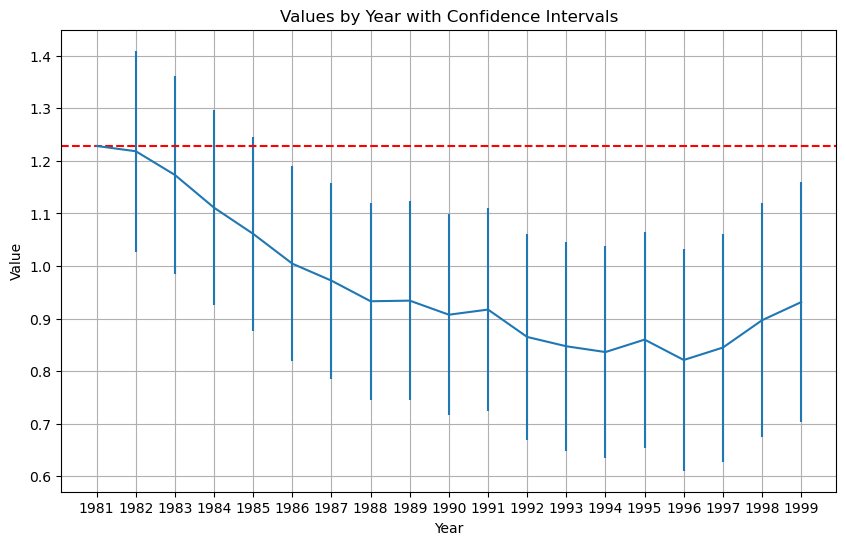

In [107]:
time_coefs_sic['upper'] = time_coefs_sic['CI_h'] - time_coefs_sic['coef']
time_coefs_sic['lower'] = time_coefs_sic['coef'] - time_coefs_sic['CI_l']
time_coefs_sic.loc[time_coefs_sic['year'] == '1981', ['upper','lower']] = 0

cis = time_coefs_sic[['lower','upper']].T
# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(x=time_coefs_sic['year'],y=time_coefs_sic['coef'],yerr=cis)
plt.axhline(y=coef_81, linestyle='dashed', color='r')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Values by Year with Confidence Intervals')
plt.grid(True)
plt.show()

,year,coef,CI_l,CI_h
0,1981,1.228403,0.000000,0.000000
1,1982,1.218424,1.027256,1.409592
2,1983,1.173297,0.985423,1.361171
3,1984,1.111012,0.926054,1.295970
4,1985,1.061254,0.876589,1.245919


# DAG model and testing

In [ ]:
DAG3 = """graph [
directed 1

node [
    id 0
    label "rmkvaf"
    ]

node [
    id 1
    label "rxrd"
    ]
    
node [
    id 2
    label "rsales"
    ]

node [
    id 3
    label "gspilltecIV"
    ]

node [
    id 4
    label "gspillsicIV"
    ]

node [
    id 5
    label "pat_count"
    ]

node [
    id 7
    label "rppent"
    ]

edge [
    source 5
    target 0
    ]

edge [
    source 5
    target 7
    ]


edge [
    source 3
    target 1
    ]


edge [
    source 4
    target 1
    ]


edge [
    source 4
    target 2
    ]


edge [
    source 1
    target 7
    ]


edge [
    source 1
    target 5
    ]


edge [
    source 7
    target 2
    ]


edge [
    source 2
    target 0
    ]

edge [
    source 7
    target 0
    ]

]
    
    """

In [ ]:
model = CausalModel(
    data=df,
    treatment='gspilltecIV',
    outcome='rmkvaf',
    graph=DAG3)

model.view_model()

In [ ]:
# identify estimand
estimand = model.identify_effect()
print(estimand)

In [ ]:
# obtain estimates
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')

print(estimate.value)

In [ ]:
# refutation test
refute_subset = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.4)

print(refute_subset)

# Scrap Code

X_spills = df[['gspilltecIV', 'gspillsicIV']]

(X_trainsp,
 X_testsp,
 y_trainsp,
 y_testsp) = skm.train_test_split(X_spills,
                                df['rmkvaf'],
                                test_size=0.3,
                                random_state=0) 

In [ ]:
# # Try a neural network
# one_layers = [
#     (1),
#     (2),
#     (3),
#     (4),
#     (5)
# ]

# two_layers = [
#     (1,1),(1,2),(1,3),
#     (2,1),(2,2),(2,3),(2,4),
#     (3,1),(3,2),(3,3),(3,4),(3,5),
#     (4,1),(4,2),(4,3),(4,4),(4,5),
#     (5,1),(5,2),(5,3),(5,4),(5,5)
# ]

# # Use DML with a PLR equation, keeping spillovers entering linearly
# # Use Random Forest as the ML model

# # Specify doubleML data model

# x_vars = ['pat_count','rsales','rppent','emp','rxrd']
# data_dml_tec = dml.DoubleMLData(df,
#                                  y_col='rmkvaf',
#                                  d_cols='gspilltec',
#                                  x_cols=x_vars)

# RF_DML = RF(max_features=3, random_state=0)

# # Implement PLR DML estimation with gspilltec linear

# dml_plr_tec = dml.DoubleMLPLR(data_dml_tec,
#                                 ml_l = RF_DML,
#                                 ml_m = RF_DML,
#                                 n_folds = 3)

# dml_plr_tec.fit(store_predictions=True)
# print(dml_plr_tec.summary)